In [1]:
import pandas as pd
import pickle
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic as ct

# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy
nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


In [2]:
# # Import the different sheets.

# yrs = ["2019", "2020"]
# df = pd.DataFrame()

# for sheet in yrs:
#     temp_df = pd.read_excel("../data/2019 - 2020 JCRP Metrics -EB.xlsx", 
#                    sheet_name = sheet)
#     df = pd.concat([df, temp_df])
    
# df = df.dropna(axis=0, how="all")

# # A lot of the Title entries are "Selected Abstracts..." and are from "Literature Update" article types.
# # However, the Vol 40 doesn't have article type so have to look through titles.

# df = df[df["Title"].str.contains("Selected Abstracts From Recent Publications") == False]

In [3]:
with open("../data/dataframe_with_abstracts.pickle", "rb") as read_file:
    df = pickle.load(read_file)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          160 non-null    int64         
 1   Date assessed                  159 non-null    datetime64[ns]
 2   Volume                         160 non-null    float64       
 3   Issue                          160 non-null    float64       
 4   Article Type                   84 non-null     object        
 5   Artcle metric                  157 non-null    float64       
 6   Tweets                         158 non-null    float64       
 7   Facebook                       82 non-null     float64       
 8   Mendeley                       158 non-null    float64       
 9   2021 citations                 149 non-null    float64       
 10  2020 citations                 129 non-null    float64       
 11  2019 citations     

### Tokenize the text.

In [7]:
# Use spaCy to tokenize the text.

docs = list(nlp.pipe(df.Full_Abstract))
df['spacy_doc'] = docs

In [25]:
# Text preprocessing. Removing stop words, puncuation, numbers, and user mentions (i.e., @xx).
# (also remove text used in the search of Twitter (i.e., "new", "years", "resolution")).

docs_clean = [[w.text.lower() for w in doc if \
               (not w.is_stop and not w.is_punct and not w.like_num and\
                w.text.lower() != "\xa0" and\
                w.text.lower() not in ("ml", "kg", "min", "mm", "hg")
               )] for doc in docs]
df['docs_clean'] = docs_clean

In [26]:
df["Text_clean"] = df["docs_clean"].map(lambda x: " ".join(x))

In [27]:
# Merge tokens together.
docs_list_clean = [' '.join(doc) for doc in df['docs_clean']]
docs_list_clean[:3]

['chronic conditions chronic obstructive pulmonary disease copd cardiovascular disease cvd contribute significant burden patients experience reduction physical functioning psychological health quality life sentinel symptom copd cvd breathlessness rehabilitation programs proven reduce disease symptoms increase levels physical psychological wellness pulmonary cardiac rehabilitation programs recommended international national guidelines managing copd cvd given programs seek reduce breathlessness improve physical psychological functioning people copd cvd review examines concordant evidence based interventions rehabilitation guidelines findings review indicate concordance program design location programs types health professionals involved program delivery assessments patient commencement completion program delivery educational topics minor deviations related disease specific topics apart disease specific recommendations main divergence rehabilitation guidelines found dietary screening insp

### Exploring possible topics.

In [28]:
# Function to display the top words associated with the topics.

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def topics_explore(vectorizer, num_topics, doc_lst, redux_model="NMF"):
    
    if redux_model == "NMF" or redux_model == "LSA":
        X = vectorizer.fit_transform(doc_lst)

        if redux_model == "LSA":
            topics = TruncatedSVD(num_topics)
        else:
            topics = NMF(num_topics)

        doc_topic = topics.fit_transform(X)

        return display_topics(topics, vectorizer.get_feature_names(), 10)
    
    elif redux_model == "LDA":
        vectorizer.fit(doc_lst)
        doc_word = vectorizer.transform(doc_lst).transpose()
        corpus = matutils.Sparse2Corpus(doc_word)
        id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
        lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5)
        
        return lda.print_topics()
    
    else:
            return "Select either LSA, NMF, or LDA."

In [30]:
tv = TfidfVectorizer(stop_words='english', 
                     min_df = 0.01, 
                     max_df = 0.8,
                     ngram_range=(2,4))

topics_explore(tv, 5, docs_list_clean, "LSA")


Topic  0
cardiac rehabilitation, exercise training, quality life, physical activity, exercise capacity, chronic obstructive, obstructive pulmonary, pulmonary disease, chronic obstructive pulmonary disease, obstructive pulmonary disease

Topic  1
obstructive pulmonary, chronic obstructive pulmonary disease, chronic obstructive, chronic obstructive pulmonary, pulmonary disease, obstructive pulmonary disease, obstructive pulmonary disease copd, pulmonary disease copd, disease copd, patients copd

Topic  2
exercise training, blood pressure, heart rate, heart failure, oxygen uptake, cardiopulmonary exercise, cardiorespiratory fitness, ejection fraction, exercise test, hfpef patients

Topic  3
covid 19, physical activity, quality life, 19 pandemic, covid 19 pandemic, exercise capacity, related quality, health related quality life, health related quality, related quality life

Topic  4
covid 19, 19 pandemic, covid 19 pandemic, coronavirus disease 2019 covid, disease 2019, disease 2019 covid,

In [31]:
cv = CountVectorizer(stop_words='english', 
                     min_df = 0.002, 
                     max_df = 0.70,
                     ngram_range=(2,3))

topics_explore(cv, 5, docs_list_clean, "NMF")

/Users/jamespeterman/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
cardiac rehabilitation, rehabilitation cr, cardiac rehabilitation cr, cr program, o2 peak, cardiovascular disease, exercise training, quality life, cr programs, heart failure

Topic  1
weight loss, loss goal, weight loss goal, overweight obese, set weight, set weight loss, loss goal attended, goal attended, setting weight, setting weight loss

Topic  2
physical activity, obstructive pulmonary disease, chronic obstructive, obstructive pulmonary, pulmonary disease, chronic obstructive pulmonary, home based, exercise capacity, quality life, moderate vigorous

Topic  3
cpx testing, oxygen uptake, symptomatic hf, o2peakrd measured, association o2peakrd, following maximal, wide range, heart failure, cardiopulmonary exercise, peak oxygen

Topic  4
emf group, rehab emf group, rehab emf, exercise rehabilitation, emf patients, quality life, vs respectively, group showed, emf group showed, functional capacity


### Explore topics according to popularity.

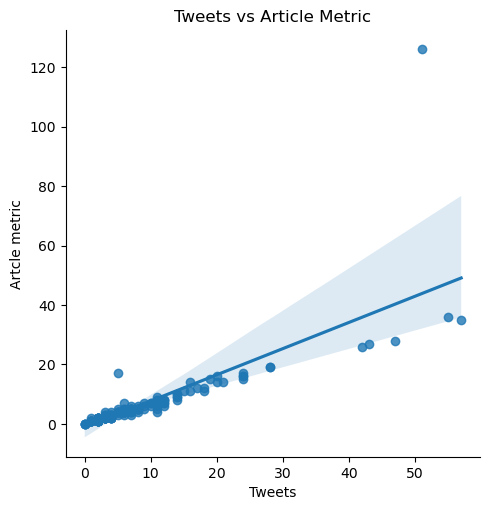

In [5]:
sns.lmplot(x="Tweets",
              y="Artcle metric",
              data=df)
plt.title("Tweets vs Article Metric")

plt.show()

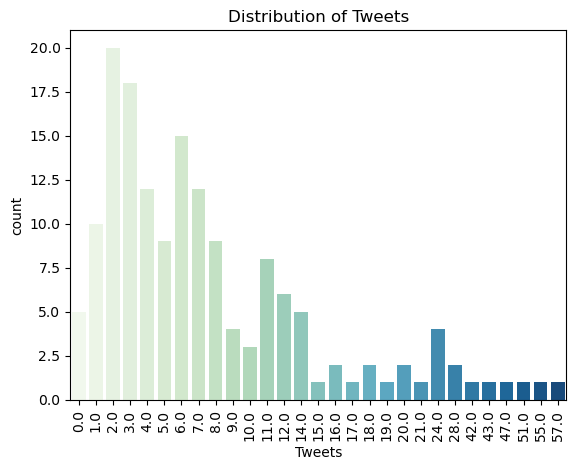

In [6]:
sns.countplot(x="Tweets",
              data=df,
              palette="GnBu")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Distribution of Tweets")

plt.show()

In [32]:
# Create a rank according to Twitter popularity.

df["twitter_rank"] = df.Tweets.rank(pct=True)

In [35]:
df_bottom_tweets = df.query("twitter_rank < 0.33")
docs_list_bottom = [' '.join(doc) for doc in df_bottom_tweets['docs_clean']]


df_top_tweets = df.query("twitter_rank > 0.67")
docs_list_top = [' '.join(doc) for doc in df_top_tweets['docs_clean']]


In [39]:
# Look at topics within the BOTTOM of twitter popularity.

tv = TfidfVectorizer(stop_words='english', 
                     min_df = 0.01, 
                     max_df = 0.8,
                     ngram_range=(2,4))

topics_explore(tv, 5, docs_list_bottom, "LSA")


Topic  0
obstructive pulmonary, chronic obstructive, pulmonary disease, chronic obstructive pulmonary disease, chronic obstructive pulmonary, obstructive pulmonary disease, home based, patients chronic obstructive pulmonary, patients chronic obstructive, patients chronic

Topic  1
covid 19, covid 19 pandemic, 19 pandemic, reduction pa, exercise training, physical performance, home confinement, pa patients, physical activity, heart failure

Topic  2
blood pressure, exercise training, ihg training, cardiac rehabilitation, aneurysm expansion, self efficacy, mait hait, acute coronary syndrome, coronary syndrome, patients obesity

Topic  3
early rehabilitation, high intensity, acute heart, acute heart failure, heart failure, rehabilitation group, barthel index, patients acute, patients acute heart, patients acute heart failure

Topic  4
weight loss, weight loss goal, loss goal, cardiac rehabilitation, self efficacy, follow appointment, yr follow, recommendation attend, cr program, acute co

In [40]:
# Look at topics within the TOP of twitter popularity.

tv = TfidfVectorizer(stop_words='english', 
                     min_df = 0.01, 
                     max_df = 0.8,
                     ngram_range=(2,4))

topics_explore(tv, 5, docs_list_top, "LSA")


Topic  0
quality life, cardiac rehabilitation, exercise capacity, exercise training, exercise prescription, cardiovascular disease, physical activity, pulmonary rehabilitation, cr quality, quality evidence

Topic  1
o2 hr, fall risk, cpx parameters, copd patients, patients copd, chronic obstructive pulmonary disease, obstructive pulmonary, chronic obstructive, chronic obstructive pulmonary, obstructive pulmonary disease

Topic  2
based cr, home based, declining participate, participate cr, home based cr, declining participate cr, based cr program, exercise prescription, facility based, identified patients

Topic  3
o2 peak, early termination, breathing pattern, home based, groups hfref, hfref copd, intermediate frail, exercise training, based cr, exercise rehabilitation

Topic  4
risk factors, exercise prescription, cvd cvd, cvd risk, cvd risk factors, o2 peak, acp education, pulmonary rehabilitation, valve repair, valve repair replacement


### Scatter Text Figure.

In [50]:
df_scatter = pd.concat([df_bottom_tweets[["twitter_rank", "Full_Abstract"]], 
                        df_top_tweets[["twitter_rank", "Full_Abstract"]]])

df_scatter["Popularity"] = df_scatter.twitter_rank.map(lambda x: "Top" if x>0.5 else "Bottom")


In [51]:
import scattertext as st

# Build the corpus.

corpus = st.CorpusFromPandas(
    df_scatter,
    category_col =  "Popularity",
    text_col = "Full_Abstract", 
    nlp=st.whitespace_nlp_with_sentences
).build()

In [52]:
# Create the HTML.

html = st.produce_scattertext_explorer(
        corpus,
        category= "Top", 
        category_name=  "Top", 
        not_category_name= "Bottom", 
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
#         metadata=df_scatter['User_ID'],
        )

In [54]:
# Explore the HTML.

open('../images/abstract_popularity.html', 'wb').write(html.encode('utf-8'));

### Word Clouds.

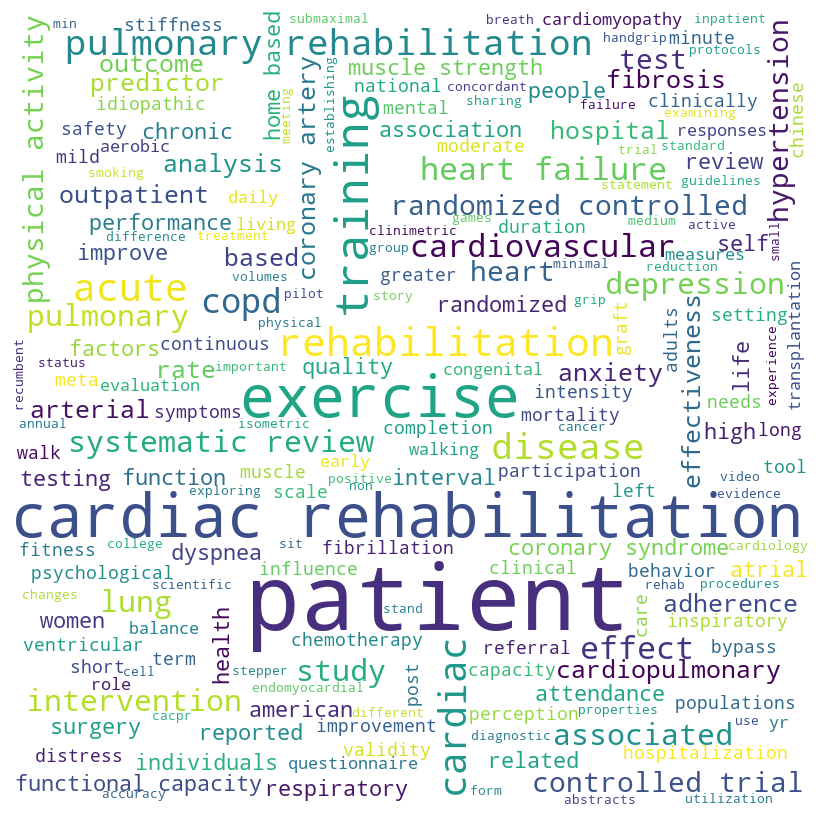

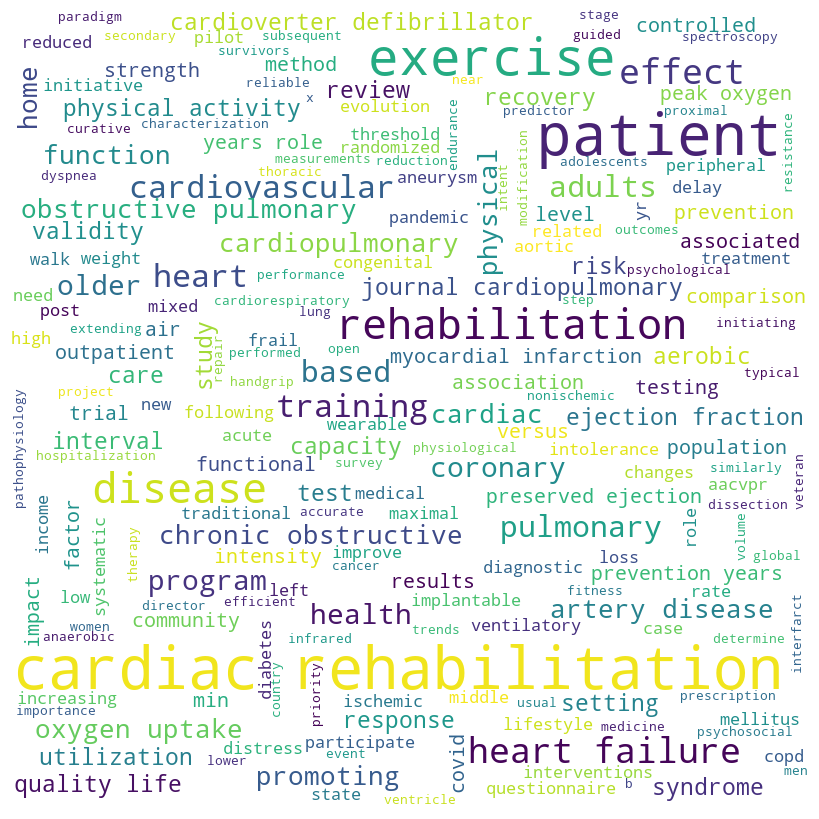

In [10]:
# Create a word cloud to illustrate the top words/phrases.

volumes = ["39", "40"]

for vol in volumes:
    
    df_text = df.query(f"Volume == {vol}")

    words = " ".join(df_text.Text_clean)

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
#     plt.savefig(f"../images/wordcloud_vol{vol}")